## DL assignment #1 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import PIL
import requests
from tqdm.notebook import tqdm
import numpy as np
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are using {}".format(device))

We are using cuda


### Implement the datasets and dataloaders, visualize some data samples

Datasets and dataloaders

In [2]:
import os
from PIL import Image

class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.image_paths = []
        self.image_labels = []
        for index, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.image_labels.append(index)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.image_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = ChestXrayDataset(root_dir='chest_xray_64/train', transform=transform)
val_dataset = ChestXrayDataset(root_dir='chest_xray_64/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Visualize

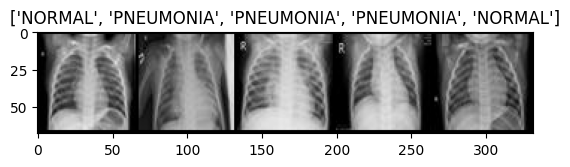

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images, classes = next(iter(train_loader))
images, classes = images[:5], classes[:5]
out = torchvision.utils.make_grid(images)
imshow(out, title=[train_dataset.classes[x] for x in classes])

### Implement the MLP model

In [4]:
from torch import nn

class MLP(nn.Module):
    def __init__(self, input_features = 3 * 64 * 64):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_features, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = MLP()
print(model)

MLP(
  (fc1): Linear(in_features=12288, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=2, bias=True)
)


### Implement the CNN model

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=0)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=2, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.conv7(x)
        x = torch.flatten(x, 1)
        return x
    
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
)


### Implement the training code

In [6]:
from torch import optim

def train(model, batchsize, epochs, model_name, train_dataset, val_dataset, save_path='weights'):

    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_train = []
    loss_val = []
    accuracy_train = []
    accuracy_val = []
    best_val_accuracy = 0.0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        train_accuracy = 100 * train_correct / train_total
        loss_train.append(train_loss)
        accuracy_train.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_accuracy = 100 * val_correct / val_total
        loss_val.append(val_loss)
        accuracy_val.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            model_save_path = os.path.join(save_path, f'{model_name}.pth')
            os.makedirs(save_path, exist_ok=True)
            torch.save(model.state_dict(), model_save_path)

        print(f'Epoch {epoch + 1}/{epochs} Training Loss: {train_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}% Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%')
    print('Finished Training and Evaluation')

    return loss_train, loss_val, accuracy_train, accuracy_val

Include plots for the training and validation losses and accuracies

In [7]:
def visualize(loss_train, loss_val, accuracy_train, accuracy_val):

    epochs_range = range(1, len(loss_train) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss_train, label='Training Loss')
    plt.plot(epochs_range, loss_val, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracy_train, label='Training Accuracy')
    plt.plot(epochs_range, accuracy_val, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

### Train the MLP model

In [8]:
model_MLP = MLP().to(device)
loss_train_MLP, loss_val_MLP, accuracy_train_MLP, accuracy_val_MLP = train(model_MLP, batchsize = 32, epochs = 30, train_dataset = train_dataset, val_dataset = val_dataset, model_name = 'MLP')

Epoch 1/30 Training Loss: 0.3450, Accuracy: 84.66% Validation Loss: 0.3598, Accuracy: 83.33%
Epoch 2/30 Training Loss: 0.1835, Accuracy: 92.89% Validation Loss: 0.5352, Accuracy: 76.92%
Epoch 3/30 Training Loss: 0.1460, Accuracy: 94.52% Validation Loss: 0.5273, Accuracy: 78.69%
Epoch 4/30 Training Loss: 0.1600, Accuracy: 93.71% Validation Loss: 1.1617, Accuracy: 69.87%
Epoch 5/30 Training Loss: 0.1350, Accuracy: 94.79% Validation Loss: 0.9675, Accuracy: 72.76%
Epoch 6/30 Training Loss: 0.1293, Accuracy: 94.84% Validation Loss: 0.9215, Accuracy: 73.72%
Epoch 7/30 Training Loss: 0.1233, Accuracy: 95.40% Validation Loss: 0.9568, Accuracy: 72.12%
Epoch 8/30 Training Loss: 0.1276, Accuracy: 95.13% Validation Loss: 0.4785, Accuracy: 82.05%
Epoch 9/30 Training Loss: 0.1178, Accuracy: 95.48% Validation Loss: 1.5983, Accuracy: 67.63%
Epoch 10/30 Training Loss: 0.1249, Accuracy: 95.13% Validation Loss: 0.4001, Accuracy: 82.37%
Epoch 11/30 Training Loss: 0.1283, Accuracy: 95.40% Validation Loss: 

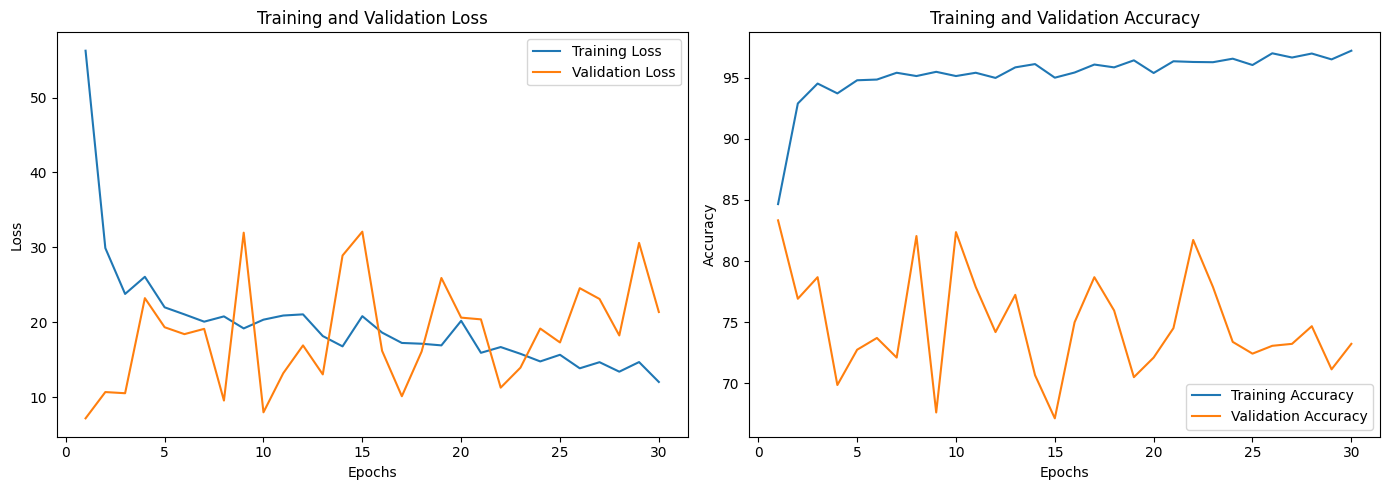

In [9]:
visualize(loss_train_MLP, loss_val_MLP, accuracy_train_MLP, accuracy_val_MLP)

### Train the CNN model

In [10]:
model_CNN = CNN().to(device)
loss_train_CNN, loss_val_CNN, accuracy_train_CNN, accuracy_val_CNN = train(model_CNN, batchsize = 32, epochs = 30, train_dataset = train_dataset, val_dataset = val_dataset, model_name = 'CNN')

Epoch 1/30 Training Loss: 0.5259, Accuracy: 82.13% Validation Loss: 0.9189, Accuracy: 72.76%
Epoch 2/30 Training Loss: 0.1841, Accuracy: 92.89% Validation Loss: 0.6314, Accuracy: 75.00%
Epoch 3/30 Training Loss: 0.1390, Accuracy: 94.73% Validation Loss: 1.0083, Accuracy: 75.16%
Epoch 4/30 Training Loss: 0.1216, Accuracy: 95.26% Validation Loss: 0.4628, Accuracy: 80.93%
Epoch 5/30 Training Loss: 0.1027, Accuracy: 96.18% Validation Loss: 0.4982, Accuracy: 80.13%
Epoch 6/30 Training Loss: 0.0984, Accuracy: 96.38% Validation Loss: 0.5053, Accuracy: 82.05%
Epoch 7/30 Training Loss: 0.0863, Accuracy: 96.64% Validation Loss: 1.0065, Accuracy: 77.08%
Epoch 8/30 Training Loss: 0.0846, Accuracy: 96.86% Validation Loss: 0.5401, Accuracy: 82.69%
Epoch 9/30 Training Loss: 0.0641, Accuracy: 97.76% Validation Loss: 0.7531, Accuracy: 80.29%
Epoch 10/30 Training Loss: 0.0682, Accuracy: 97.32% Validation Loss: 0.7250, Accuracy: 79.49%
Epoch 11/30 Training Loss: 0.0635, Accuracy: 97.45% Validation Loss: 

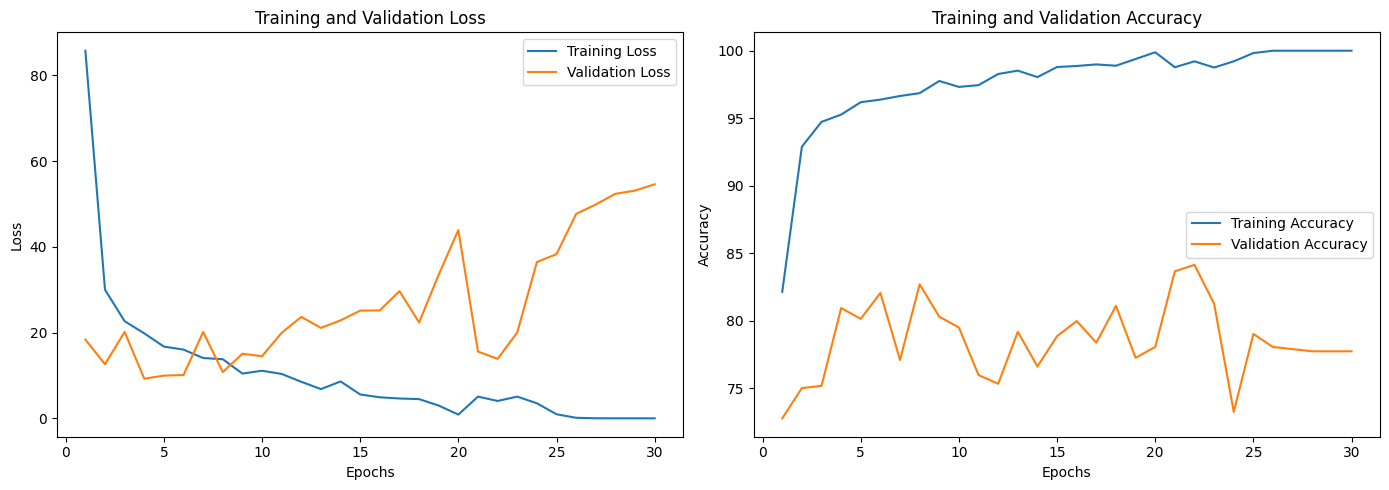

In [11]:
visualize(loss_train_CNN, loss_val_CNN, accuracy_train_CNN, accuracy_val_CNN)

## Implement  regularization techniques

## First technique


Data augmentation

In [19]:
train_augment_transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.RandomCrop((64, 64)),
    transforms.RandomHorizontalFlip(),
    # Using those transform below performs bad
    # transforms.RandomRotation(10),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

val_augment_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_aug_dataset = ChestXrayDataset(root_dir='chest_xray_64/train', transform=train_augment_transform)
val_aug_dataset = ChestXrayDataset(root_dir='chest_xray_64/val', transform=val_augment_transform)


In [20]:
model_CNN_aug = CNN().to(device)
loss_train_CNN_aug, loss_val_CNN_aug, accuracy_train_CNN_aug, accuracy_val_CNN_aug = train(model_CNN_aug, batchsize = 32, epochs = 30, train_dataset = train_aug_dataset, val_dataset = val_aug_dataset, model_name = 'CNN_Aug')

Epoch 1/30 Training Loss: 0.6675, Accuracy: 73.52% Validation Loss: 0.4709, Accuracy: 81.25%
Epoch 2/30 Training Loss: 0.4212, Accuracy: 82.76% Validation Loss: 0.4774, Accuracy: 80.29%
Epoch 3/30 Training Loss: 0.3285, Accuracy: 86.35% Validation Loss: 0.4230, Accuracy: 82.37%
Epoch 4/30 Training Loss: 0.2968, Accuracy: 88.02% Validation Loss: 0.3357, Accuracy: 85.42%
Epoch 5/30 Training Loss: 0.2649, Accuracy: 89.13% Validation Loss: 0.3909, Accuracy: 85.10%
Epoch 6/30 Training Loss: 0.2420, Accuracy: 89.99% Validation Loss: 0.4217, Accuracy: 84.29%
Epoch 7/30 Training Loss: 0.2470, Accuracy: 89.80% Validation Loss: 0.3228, Accuracy: 87.50%
Epoch 8/30 Training Loss: 0.2285, Accuracy: 90.61% Validation Loss: 0.3595, Accuracy: 86.86%
Epoch 9/30 Training Loss: 0.2307, Accuracy: 90.84% Validation Loss: 0.5496, Accuracy: 78.53%
Epoch 10/30 Training Loss: 0.2226, Accuracy: 91.20% Validation Loss: 0.4753, Accuracy: 80.77%
Epoch 11/30 Training Loss: 0.2050, Accuracy: 92.02% Validation Loss: 

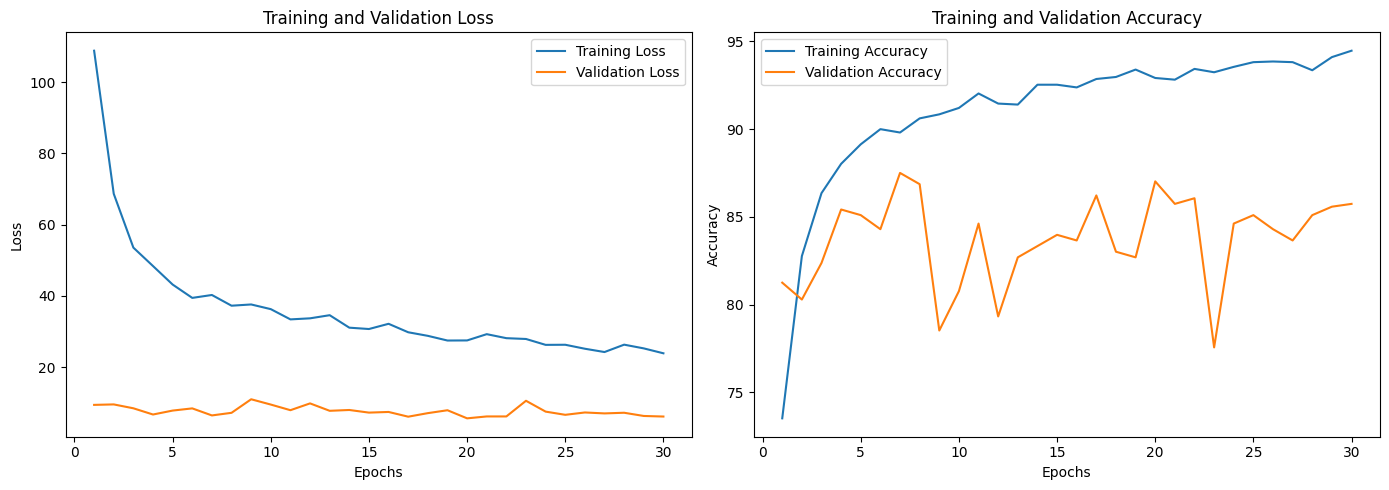

In [21]:
visualize(loss_train_CNN_aug, loss_val_CNN_aug, accuracy_train_CNN_aug, accuracy_val_CNN_aug)

## Second technique


Dropout

In [15]:
class CNN_dropout(CNN):
    def __init__(self, dropout_conv=0.2, dropout_fc=0.5):
        super(CNN_dropout, self).__init__()
        self.dropout_conv = nn.Dropout(p=dropout_conv)
        self.dropout_fc = nn.Dropout(p=dropout_fc)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(self.dropout_conv(x))
        x = self.relu(self.conv2(x))
        x = self.pool2(self.dropout_conv(x))
        x = self.relu(self.conv3(x))
        x = self.pool3(self.dropout_conv(x))
        x = self.dropout_conv(self.relu(self.conv4(x)))
        x = self.dropout_conv(self.relu(self.conv5(x)))
        x = self.dropout_conv(self.relu(self.conv6(x)))
        x = self.dropout_fc(self.conv7(x))
        x = torch.flatten(x, 1)
        return x

In [16]:
model_CNN_drop = CNN().to(device)
loss_train_CNN_drop, loss_val_CNN_drop, accuracy_train_CNN_drop, accuracy_val_CNN_drop = train(model_CNN_drop, batchsize = 32, epochs = 30, train_dataset = train_dataset, val_dataset = val_dataset, model_name = 'CNN_drop')

Epoch 1/30 Training Loss: 0.5725, Accuracy: 80.23% Validation Loss: 0.5037, Accuracy: 79.81%
Epoch 2/30 Training Loss: 0.1594, Accuracy: 94.15% Validation Loss: 0.7115, Accuracy: 75.80%
Epoch 3/30 Training Loss: 0.1415, Accuracy: 94.15% Validation Loss: 0.4437, Accuracy: 85.74%
Epoch 4/30 Training Loss: 0.1237, Accuracy: 95.46% Validation Loss: 0.4990, Accuracy: 80.77%
Epoch 5/30 Training Loss: 0.0992, Accuracy: 96.13% Validation Loss: 0.8526, Accuracy: 74.52%
Epoch 6/30 Training Loss: 0.0895, Accuracy: 96.59% Validation Loss: 1.0370, Accuracy: 74.20%
Epoch 7/30 Training Loss: 0.0876, Accuracy: 96.63% Validation Loss: 0.6967, Accuracy: 80.45%
Epoch 8/30 Training Loss: 0.0812, Accuracy: 96.86% Validation Loss: 0.7870, Accuracy: 79.01%
Epoch 9/30 Training Loss: 0.0703, Accuracy: 97.32% Validation Loss: 1.0451, Accuracy: 76.12%
Epoch 10/30 Training Loss: 0.0680, Accuracy: 97.32% Validation Loss: 1.0034, Accuracy: 76.44%
Epoch 11/30 Training Loss: 0.0603, Accuracy: 97.81% Validation Loss: 

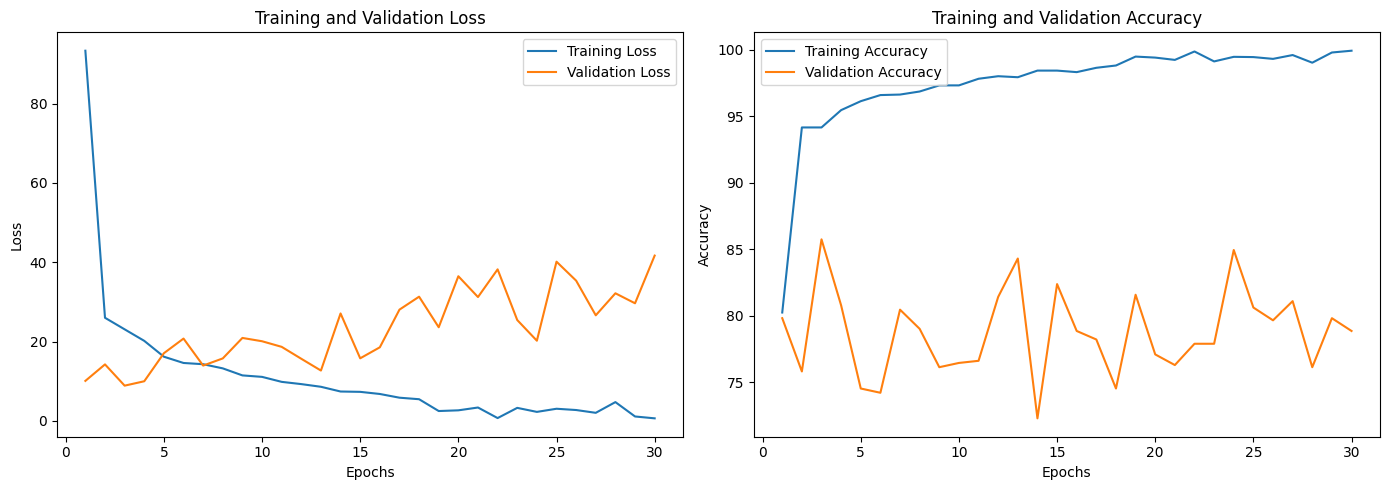

In [17]:
visualize(loss_train_CNN_drop, loss_val_CNN_drop, accuracy_train_CNN_drop, accuracy_val_CNN_drop)

# Results comparison - Summary

In [18]:
table_data = [
    ['Regularization type', 'Val Loss', 'Val accuracy'],
    ['No regularization', val_loss_no_regularization, val_accuracy_no_regularization], 
    ['Early stopping', val_loss_early_stopping, val_accuracy_early_stopping],
    ['Data augmentation', val_loss_dataaugmentation, val_accuracy_dataaugmentation],
    ['L2 regularization', val_loss_weightdecay, val_accuracy_weightdecay],
    ['Dropout', val_loss_dropout, val_accuracy_dropout],
]
print("{: >20}| {: >20}| {: >20}".format(*table_data[0]))
print('-'.join(['' for i in range(65)]))
for row in table_data[1:]:
    print("{: >20}| {:20.4f}| {: >20}".format(*row))